## Configuration

### Imports

In [95]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches


# Network analysis
import networkx as nx
#import graph_tool.all as gt

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

In [9]:
sns.__version__
nx.__version__

'2.5'

### Support Functions

In [3]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None

    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.rename(columns={'user_id':'tweet_author'},inplace=True)
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.rename(columns={'user_id':'retweet_author'},inplace=True)
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                )
    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

## Data preparation

#### Getting tweets from DB...

In [4]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,tweet_author,tweet_id
0,000000000000000279465279,000001191464087064109058
1,000000000000001266667238,000001192787272975945729
2,000000000000000331220696,000001191467194519080960


In [5]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweet_author  358190 non-null  object
 1   tweet_id      358190 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


In [6]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### Getting retweets from DB...

In [ ]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

In [ ]:
df_retweets[df_retweets.duplicated()].count()

In [ ]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

#### Getting users from DB...

In [11]:
users = get_users(db.users)
display(users.head(5))

Number of sampled users with botscore in DB: 1150709


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000006953012,0.03


## 1. Botscore distribution

0.19
0.37


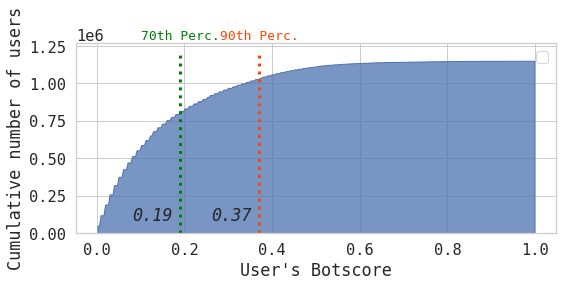

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))

h = sns.histplot(users.botscore, 
                 #bins=40,
                 #hist=False, 
                 #kde=True,  
                 element="poly",
                 cumulative=True,
                 cbar=True
                )

h.set_ylabel(ylabel='Cumulative number of users')
h.set_xlabel(xlabel='User\'s Botscore')

# vertical lines for percentiles
h_ylims = h.get_ylim()
prs = [70,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

colors = {70 : 'green',
          90 : 'orangered'}

for pr,p in zip(prs,ps):
    print(p)
    label = str(pr) + "th Perc."
    h.vlines(x=p, ymin=h_ylims[0], ymax=h_ylims[1], linewidth = 3, linestyles='dotted', color=colors[pr])
    text(x=p-0.11, y=h_ylims[1]*0.1, s= str(p), fontstyle='italic', verticalalignment='center')
    text(x=p-0.09, y=h_ylims[1]*1.09, s= label, fontstyle='normal', fontsize=13, verticalalignment='center', color=colors[pr])
    

    
# common legend
h.legend(loc="upper right")

#fig.suptitle("Botscore distribution", y=1.01)
plt.tight_layout()

#plt.savefig("images/distribution.svg")
plt.show()

/home/mattia/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.19
0.37


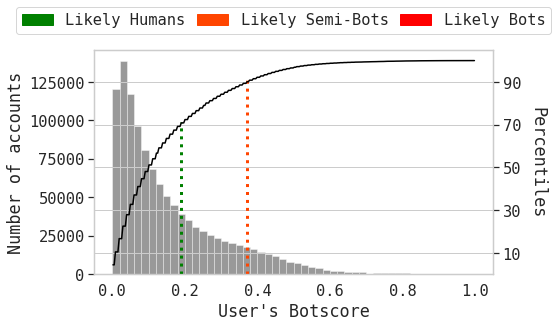

In [167]:
# subfigure 1
fig, axs = plt.subplots(1, 1, figsize=(8,5))


# distplot

g = sns.distplot(users.botscore,
                 color='black',
                 bins=50,
                 hist=True, 
                 kde=False, 
                 ax=axs)


g.set_ylabel(ylabel='Number of accounts')
g.set_xlabel(xlabel='User\'s Botscore')
g.grid(False)
    
ax2 = axs.twinx()



# cumulative


h = sns.histplot(users.botscore, 
                 color='black',
                 element="poly",
                 cumulative=True,
                 cbar=True,
                 ax = ax2,
                 fill=False,
                 stat="density"
                )

h.set_ylabel(ylabel='Percentiles', rotation=270, labelpad=25)
h.set_yticks(np.arange(0.1, 1.0, step=0.2))
h.set_yticklabels(np.arange(10, 100, step=20))

h.set_xticks(np.arange(0.0, 1.1, step=0.2))

# vertical lines for percentiles
h_ylims = h.get_ylim()
prs = [70,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

colors = {70 : 'green',
          90 : 'orangered'}

for pr,p in zip(prs,ps):
    print(p)
    label = str(pr) + "th Perc."
    h.vlines(x=p, ymin=h_ylims[0], ymax=h_ylims[1]*pr*0.0097, linewidth = 3, linestyles='dotted', color=colors[pr])
    #text(x=p-0.11, y=h_ylims[1]*0.1, s= str(p), fontstyle='italic', verticalalignment='center')
    #text(x=p-0.09, y=h_ylims[1]*1.09, s= label, fontstyle='normal', fontsize=13, verticalalignment='center', color=colors[pr])
    

h = mpatches.Patch(color='green', label='Likely Humans')
sb = mpatches.Patch(color='orangered', label='Likely Semi-Bots')
b = mpatches.Patch(color='red', label='Likely Bots')
plt.legend(handles=[h,sb,b], loc='upper left', ncol=3, mode='expand', borderaxespad=0.1, bbox_to_anchor=(-0.20, 1.1, 1.35, .1))
    

#fig.suptitle("Botscore distribution", y=1.01)
plt.tight_layout()

plt.savefig("images/distribution-v2.svg")
plt.show()

## 2. Graph properties

#### Building directed-weighted retweet graph...

In [13]:
df_edges = df_retweets.set_index('tweet_id').join(df_tweets.set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,retweet_author,tweet_author
0,000001041608534734061568,000000000000000068740712
1,000000000000002824508322,000000000000000068740712
2,000000755192640321314817,000000000000000068740712
3,000000000000000523370717,000000000000000068740712
4,000000000000003610966882,000000000000000068740712


In [14]:
df_edges = df_edges.groupby(['retweet_author','tweet_author']).size().reset_index().rename(columns={0:'weight'})
df_edges.head(5)

,retweet_author,tweet_author,weight
0,000000000000000000002862,000000000000000026994875,1
1,000000000000000000003065,000000000000000016409683,1
2,000000000000000000003065,000000000000000121385551,1
3,000000000000000000003065,000000000000000207741909,1
4,000000000000000000003968,000000000000000014436030,1


In [15]:
df_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6037031 entries, 0 to 6037030
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   retweet_author  object
 1   tweet_author    object
 2   weight          int64 
dtypes: int64(1), object(2)
memory usage: 138.2+ MB


In [16]:
%%time
implicated_users = []
implicated_users = list(set(list(df_edges.retweet_author.unique()) + list(df_edges.tweet_author.unique())))
#print("Implicated users:", len(implicated_users))

df_users = users[users._id.isin(implicated_users)]
print("Users with botscore:", len(df_users))

print("Retweets without botscore:", len(df_edges))
df_edges = df_edges[(df_edges.retweet_author.isin(df_users._id)) & (df_edges.tweet_author.isin(df_users._id))]
print("Retweets with botscore:", len(df_edges))

Users with botscore: 1150709
Retweets without botscore: 6037031
Retweets with botscore: 4313219
CPU times: user 8.71 s, sys: 445 ms, total: 9.16 s
Wall time: 9.12 s


### Using networkx

In [17]:
%%time
G = nx.from_pandas_edgelist(df=df_edges, source='tweet_author', target='retweet_author', edge_attr='weight', create_using=nx.DiGraph)

CPU times: user 16.8 s, sys: 456 ms, total: 17.3 s
Wall time: 17.3 s


In [18]:
G.number_of_nodes()

1027305

In [19]:
%%time
degs = G.degree()

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 15.7 µs


In [22]:
node_attr = df_users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

In [23]:
nx.write_graphml(G, "graphs/filtered-general-network.graphml")

In [21]:
df_edges.head()

,retweet_author,tweet_author,weight
0,000000000000000000002862,000000000000000026994875,1
4,000000000000000000003968,000000000000000014436030,1
6,000000000000000000003971,000000000000000035222818,1
7,000000000000000000003971,000000000000000046529156,1
8,000000000000000000003971,000000000000000057662387,1


### Using graph-tool

In [22]:
%%time

X = gt.Graph(directed=True)
eweight = X.new_edge_property('int')
user_ids = X.add_edge_list(df_edges.values, hashed=True, hash_type='string', eprops=[eweight])

CPU times: user 15.5 s, sys: 325 ms, total: 15.9 s
Wall time: 15.7 s


In [23]:
%%time

# botscore for nodes
user_botscores_dic = df_users.set_index('_id').to_dict('index')
node_botscores = []
for user_id in user_ids:
    node_botscore = user_botscores_dic[user_id]['botscore']
    node_botscores.append(node_botscore)

CPU times: user 5.53 s, sys: 327 ms, total: 5.86 s
Wall time: 5.86 s


In [24]:
%%time
vbotscores = X.new_vertex_property(value_type='float', vals=node_botscores)

CPU times: user 293 ms, sys: 251 µs, total: 293 ms
Wall time: 289 ms


In [25]:
print(user_ids[2])
print(vbotscores[2])

000000000000000000003968
0.05


#### Three situations to compare. We sort users in ascending order of botscore:
##### 1. users < 70th percentile (legitimate network)
##### 2. users < 90th (shady network)
##### 3. all network (bot-interfered network)

In [26]:
%%time

df = pd.DataFrame()

prs = [70,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

percentile = {70: ps[0],
              90: ps[1],
              100: 1.01}

for percentage in [70, 90, 100]:
    print("Network " + str(percentage) +"%")
    print("--------------")
    
   
    filtering_properties = []
    for b in node_botscores:
        if b < percentile[percentage]:
            filtering_properties.append(True)
        else:
            filtering_properties.append(False)



    X.set_vertex_filter(X.new_vertex_property(value_type='bool', vals=filtering_properties))
    
    print("Number of vertices:", X.num_vertices())
    print("Number of edges:", X.num_edges())

    df_percentile = pd.DataFrame.from_dict({'out-degree':X.get_out_degrees(X.get_vertices()),
                                      'in-degree':X.get_in_degrees(X.get_vertices()),
                                      'out-strenght':X.get_out_degrees(X.get_vertices(),eweight),
                                      'in-strenght':X.get_in_degrees(X.get_vertices(),eweight),
                                      'betweenness':gt.betweenness(g=X, weight=eweight)[0],
                                      'closeness':gt.closeness(g=X, weight=eweight)
                                     },
                                      orient='columns')
    
    display(df_percentile.describe())
    
    df_percentile['network'] = str(percentage)+'%'
    
    if percentage == 70:
        df = df_percentile
    else:
        df = df.append(df_percentile, ignore_index=True)
    
    X.set_vertex_filter(None)
    print()

Network 70%
--------------
Number of vertices: 709212
Number of edges: 2407485


,out-degree,in-degree,out-strenght,in-strenght,betweenness,closeness
count,709212.000000,709212.000000,709212.000000,709212.000000,7.092120e+05,646942.000000
mean,3.394591,3.394591,4.460672,4.460672,1.394929e-07,0.386851
std,8.199816,95.062469,15.397376,175.531703,4.990982e-06,0.382903
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.035354
25%,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.112347
50%,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.134364
75%,3.000000,0.000000,3.000000,0.000000,0.000000e+00,1.000000
max,364.000000,18487.000000,1018.000000,51656.000000,1.419432e-03,1.000000



Network 90%
--------------
Number of vertices: 918048
Number of edges: 3742115


,out-degree,in-degree,out-strenght,in-strenght,betweenness,closeness
count,918048.000000,918048.000000,918048.000000,918048.000000,9.180480e+05,884839.000000
mean,4.076165,4.076165,5.390199,5.390199,1.315907e-07,0.377378
std,11.028117,115.960270,20.753911,218.581074,4.413099e-06,0.375421
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.030303
25%,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.119009
50%,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.141432
75%,3.000000,0.000000,3.000000,0.000000,0.000000e+00,0.700000
max,721.000000,23819.000000,2664.000000,73447.000000,1.180857e-03,1.000000



Network 100%
--------------
Number of vertices: 1027305
Number of edges: 4313219


,out-degree,in-degree,out-strenght,in-strenght,betweenness,closeness
count,1.027305e+06,1.027305e+06,1.027305e+06,1.027305e+06,1.027305e+06,1.006198e+06
mean,4.198577e+00,4.198577e+00,5.535806e+00,5.535806e+00,1.148991e-07,3.798974e-01
std,1.198663e+01,1.211918e+02,2.234184e+01,2.264189e+02,3.887970e-06,3.730897e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.030303e-02
25%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.229882e-01
50%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.468714e-01
75%,3.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,6.666667e-01
max,7.850000e+02,2.555200e+04,2.707000e+03,8.031100e+04,8.372104e-04,1.000000e+00



CPU times: user 3d 10h 36min 21s, sys: 6min 18s, total: 3d 10h 42min 39s
Wall time: 4h 28min 51s


CPU times: user 5.86 s, sys: 2.97 s, total: 8.82 s
Wall time: 5.16 s


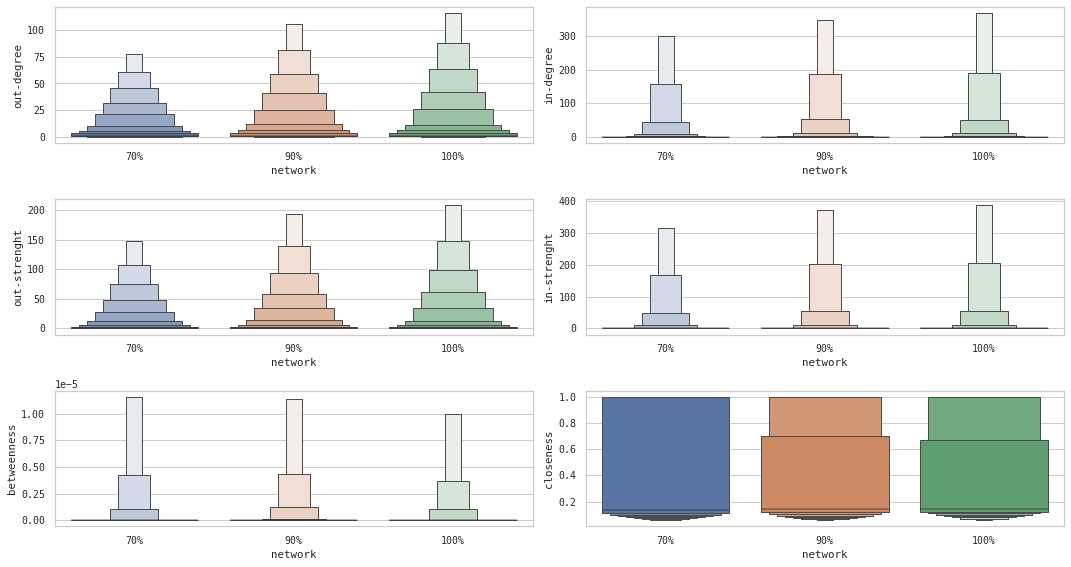

In [27]:
%%time

rows = 3
columns = 2

fig, axs = plt.subplots(rows, columns, figsize=(15,8))

row=0
column=0
for cat in ['out-degree','in-degree','out-strenght','in-strenght', 'betweenness', 'closeness']:
    ax = axs[row][column]
    ax = sns.boxenplot(data=df,
                       x='network',
                       y=cat,
                       order=['70%','90%','100%'],
                       ax=ax,
                       showfliers=False,
                       dodge=False,
                       k_depth=8,
                       scale='linear'
                    )
    
    column=(column+1)%columns
    if column==0:
        row=row+1

plt.tight_layout()
plt.savefig("images/description-networks.svg")

### 3. Graph properties per botscore

In [28]:
df_all = df[df.network=='100%']
df_all = pd.DataFrame(df_all)
df_all['botscore'] = node_botscores
df_all.head()

,out-degree,in-degree,out-strenght,in-strenght,betweenness,closeness,network,botscore
1627260,1,0,1,0,0.000000e+00,0.107573,100%,0.09
1627261,20,4,25,4,7.735646e-08,0.120536,100%,0.06
1627262,1,0,1,0,0.000000e+00,0.103589,100%,0.05
1627263,10,10184,16,14987,6.377108e-05,0.115555,100%,0.01
1627264,13,44,13,44,4.645568e-06,0.133785,100%,0.12


In [29]:
BINS=20

rows = 3
columns = 2

## balance dataset for regression
df_balanced=df_all
df_balanced['botscore']=df_balanced['botscore'].round(decimals=1)
max_size = df_balanced['botscore'].value_counts().max()
lst = [df_balanced]

for botscore, botscore_group in df_balanced.groupby('botscore'):
    print(botscore, len(botscore_group))
    lst.append(botscore_group.sample(max_size-len(botscore_group), replace=True))
    
df_balanced = pd.concat(lst, ignore_index=True).reset_index(drop=True)

0.0 332439
0.1 296448
0.2 182103
0.3 90726
0.4 73969
0.5 29966
0.6 13050
0.7 4471
0.8 3218
0.9 810
1.0 105


CPU times: user 4h 17min 46s, sys: 7h 51min 28s, total: 12h 9min 14s
Wall time: 1h 56min 28s


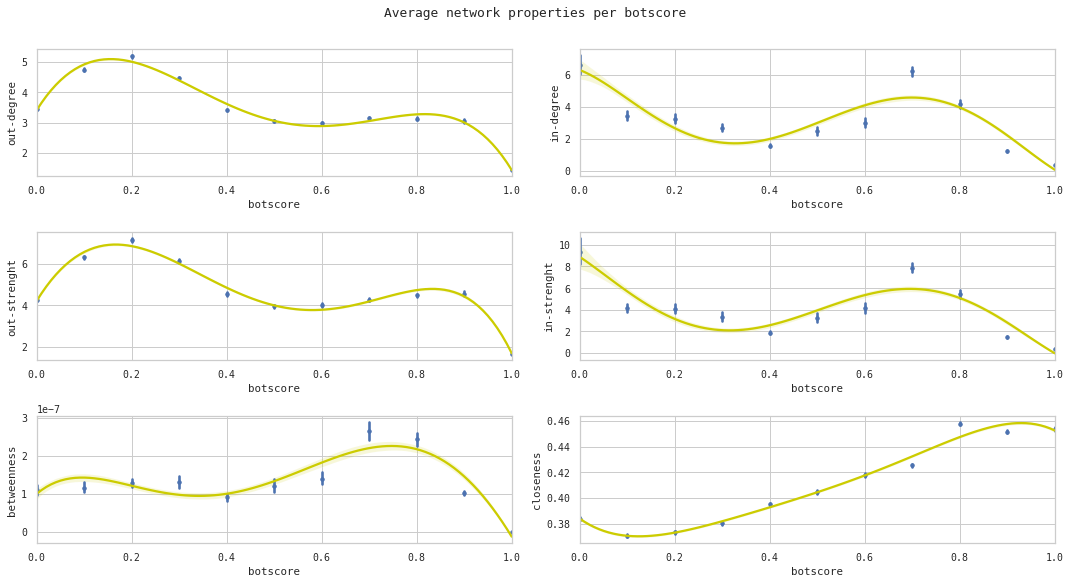

In [30]:
%%time
fig, axs = plt.subplots(rows, columns, figsize=(15,8))

row=0
column=0
for cat in ['out-degree','in-degree','out-strenght','in-strenght', 'betweenness', 'closeness']:
    
    ax = axs[row][column]

    ## plot regression
    
    ax = sns.regplot(x='botscore',
            y=cat,
            x_bins=100,
            #data=df_all,
            data=df_balanced,
            scatter_kws = {'color': 'b', 's':12},
            line_kws = {'color': '#CCCC00'},
            ax = ax,
            order=5
            )
    
    column=(column+1)%columns
    if column==0:
        row=row+1
    
    fig.suptitle("Average network properties per botscore", y=1.01)
    plt.tight_layout()
    plt.savefig("images/description-botscore.svg")